# Convolutions

Functions designed to implement 2D convolutions that have symmetric input.

In [1]:
# export
import numpy as np
import cv2
from queue import SimpleQueue
from functools import lru_cache

In [2]:
import pdb
import matplotlib.pyplot as plt
from Export.nb_ConvertToHSV import convertToGrey

In [3]:
# export
from Export.nb_PixelManipulation import iterateImageFortran, iterateImage, getChannels, timeSomething

In [4]:
frog_img = cv2.imread('Images/dat_boi.jpg')

## Create Convolutions

All convolution functions will be created with row vectors. Generic 2d convolutions are not implmeneted here. Common row vectors are defined below. lru_cache decorator remembers to the Last Recently Used 120 values of the function as they were called.

In [5]:
# export
@lru_cache()
def choice(m : int, n : int):
    if m == 1: return 1
    if n == 0: return 1
    if n == m: return 1
    if n == 1: return m
    return choice(m - 1, n) + choice(m - 1, n - 1)

def gaussian(conv_len : int):
    output = np.ndarray(conv_len, dtype = np.float32)
    output[0] = 1
    m = conv_len
    n = 0
    for i in range(1, (conv_len + 1) // 2):
        n += 1; m -= 1
        output[i] = output[i - 1] * m / n
    for i in range(conv_len // 2):
        output[-i - 1] = output[i]
    return output

def averageBlur(conv_len : int):
    output = np.ndarray(conv_len, dtype = np.float32)
    output.fill(1)
    return output

def derivative(conv_len : int):
    output = np.ndarray(conv_len, dtype = np.float32)
    i = 0
    mid_point = conv_len // 2
    neg = True
    for x in np.nditer(output, op_flags = ['writeonly']):
        if i == mid_point: x[...] = 0.; neg = False; i += 1; continue
        x[...] = -1. if neg else 1.
        i += 1
    return output 

In [6]:
gaussian(7)

array([ 1.,  6., 15., 20., 15.,  6.,  1.], dtype=float32)

In [7]:
[choice(6,0), choice(6,1), choice(6,2), choice(6,3), choice(6,4), choice(6,5), choice(6,6)]

[1, 6, 15, 20, 15, 6, 1]

In [8]:
averageBlur(5)

array([1., 1., 1., 1., 1.], dtype=float32)

In [9]:
derivative(5)

array([-1., -1.,  0.,  1.,  1.], dtype=float32)

## Request Convolutions

These functions request the high level vectors to implement common convolutions.

In [10]:
# export
def gaussianConv(n1 : int, n2 : int):
    if n1 % 2 != 1: print('Convolution size must be odd!', n1); return
    if n2 % 2 != 1: print('Convolution size must be odd!', n2); return
    conv1 = gaussian(n1); conv1 /= np.sum(conv1)
    conv2 = gaussian(n2); conv2 /= np.sum(conv2)
    return conv1, conv2

In [11]:
gauss_convs = gaussianConv(3, 5); gauss_convs

(array([0.25, 0.5 , 0.25], dtype=float32),
 array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625], dtype=float32))

In [12]:
assert(np.linalg.norm(gauss_convs[0] - (0.25, 0.5, 0.25)) < 1e-7)

In [13]:
# export
def derivativeConv(n1 : int, n2 : int):
    if n1 % 2 != 1: print('Convolution size must be odd!', n1); return
    if n2 % 2 != 1: print('Convolution size must be odd!', n2); return
    conv1 = gaussian(n1)
    conv2 = derivative(n2)
    return conv1, conv2

In [14]:
deriv_convs = derivativeConv(3, 5); deriv_convs

(array([1., 2., 1.], dtype=float32),
 array([-1., -1.,  0.,  1.,  1.], dtype=float32))

In [15]:
assert(np.linalg.norm(deriv_convs[1] - (-1, -1, 0, 1, 1)) < 1e-7)

In [16]:
# export
def averageConv(n1 : int, n2 : int):
    if n1 % 2 != 1: print('Convolution size must be odd!', n1); return
    if n2 % 2 != 1: print('Convolution size must be odd!', n2); return
    conv1 = averageBlur(n1) / n1
    conv2 = averageBlur(n2) / n2
    return conv1, conv2

In [17]:
avg_convs = averageConv(3, 5); avg_convs

(array([0.33333334, 0.33333334, 0.33333334], dtype=float32),
 array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32))

In [18]:
assert(np.linalg.norm(avg_convs[1] - np.ones(5) / 5) < 1e-7)

## Difference between Fortran and C array iteration

There is a Fortran style implementation of np.nditeration that goes through the image through columns first, then rows and then channels. The C-style implementation goes through the image rows first, then columns and then channels. It might not be realistic to assume they run at the same speed in any implementation, but in Python this appears to be the case.

In [19]:
stub_image = np.arange(12).reshape(2,2,3); stub_image

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [20]:
def testCIteraion(show_output : bool = True):
    i, j, k = 0, 0, 0
    for x in np.nditer(stub_image, order = 'C', op_flags = ['readonly']):
        assert(stub_image[i, j, k] == x)
        if show_output : print(i, j, k)
        i, j, k = iterateImage(i, j, k, 3, 2)

testCIteraion()

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2


In [21]:
timeSomething(testCIteraion, 100, False)

Average time is : 1.983642578125e-05


In [22]:
def testFIteraion(show_output : bool = True):
    i, j, k = 0, 0, 0
    for x in np.nditer(stub_image, order = 'F', op_flags = ['readonly']):
        assert(stub_image[i, j, k] == x)
        if show_output : print(i, j, k)
        i, j, k = iterateImageFortran(i, j, k, 2, 2)
        
testFIteraion()

0 0 0
1 0 0
0 1 0
1 1 0
0 0 1
1 0 1
0 1 1
1 1 1
0 0 2
1 0 2
0 1 2
1 1 2


In [23]:
timeSomething(testFIteraion, 100, False)

Average time is : 1.9946098327636718e-05


## Creating a Convolution Queue Function

A custom class will be created for a fixed size queue which keeps track of previous values.

In [24]:
# export
class fixedSizeQueue:
    def __init__(self, conv_arr : np.array, padding_value : int, **kwargs):
        n_elements = len(conv_arr)
        self.data = np.ndarray(n_elements, **kwargs)
        self.conv_arr = conv_arr
        self.padding_value = padding_value
        self.reset()
        
    def reset(self):
        self.data.fill(self.padding_value)
    
    def __len__(self):
        return len(self.data)
        
    def update(self, value = None):
        # prev_x = x is passing a value by reference
        # prev_x[...] = x means passing by value
        update_value = self.padding_value if (value is None) else value
        started = True
        for x in np.nditer(self.data, op_flags = ['readwrite']):
            if started: started = False; prev_x = x; continue
            prev_x[...] = x
            prev_x = x
        x[...] = update_value 
        
    def setValue(self, ind : int, value : int):
        self.data[ind] = value
        
    def convolve(self):
        return np.dot(self.data, self.conv_arr)

## Testing the queue used for convolution

Check that the convolution queue works as expected.

In [25]:
que = fixedSizeQueue(np.array([0, 0]), 0, dtype = np.float32)

In [26]:
que.data

array([0., 0.], dtype=float32)

In [27]:
que.update(1)

In [28]:
que.data

array([0., 1.], dtype=float32)

In [29]:
assert(np.linalg.norm(que.data - (0, 1)) < 1e-7)

In [30]:
que.update(2)

In [31]:
que.data

array([1., 2.], dtype=float32)

In [32]:
assert(np.linalg.norm(que.data - (1, 2)) < 1e-7)

In [33]:
que.update(3)

In [34]:
que.data

array([2., 3.], dtype=float32)

In [35]:
assert(np.linalg.norm(que.data - (2, 3)) < 1e-7)

## Python Queue functions

The fixed size queue keeps track of the pixel values to be convolved and stores them by value. This queue will be used to keep track of previous values to be updated and is more like an array of pointers.

There is also an inbuilt Queue function in Python (which relates to a C++ style implementation) which can take objects by reference and then the last object to put in the queue can be extracted and modified. 

This is a basic Last In First Out (LIFO) queue.

In [36]:
arr1, arr2 = np.ndarray(1), np.ndarray(2)
arr1.fill(1); arr2.fill(2)

In [37]:
python_que = SimpleQueue()

In [38]:
python_que.put(arr1)
python_que.put(arr2)

In [39]:
top_arr = python_que.get()

In [40]:
top_arr

array([1.])

In [41]:
top_arr[...] = 3

In [42]:
python_que.qsize()

1

In [43]:
arr1

array([3.])

## Single Row Convolution Functions

In [44]:
# export
def convolveRemainingPixels(update_queues : list, conv_queues : list, channels : int, update_lag : int):
    for chn_ind in range(channels):
        for _ in range(update_lag + 1):
            prev_px = update_queues[chn_ind].get()
            update_val = conv_queues[chn_ind].convolve()
            prev_px[...] = update_val
            conv_queues[chn_ind].update()
        conv_queues[chn_ind].reset()

def verticalConvolution(output_img : np.array, update_lag : int, conv_queues : list, update_queues : list):
    i, j, k = 0, 0, 0
    output_img, height, width, _, _ = getChannels(output_img)
    for px in np.nditer(output_img, order = 'F', op_flags = ['readwrite']):
        conv_queues[0].update(px)
        update_queues[0].put(px)
        i, j, _ = iterateImageFortran(i, j, k, height, width)
        if i > update_lag:
            prev_px = update_queues[0].get()
            prev_px[...] = conv_queues[0].convolve()
        if (i == 0):
            convolveRemainingPixels(update_queues, conv_queues, 1, update_lag)
    return output_img

def horizontalConvolution(output_img : np.array, update_lag : int, conv_queues : list, update_queues : list):
    i, j, k = 0, 0, 0
    output_img, _, width, channels, _ = getChannels(output_img)
    for px in np.nditer(output_img, order = 'C', op_flags = ['readwrite']):
        conv_queues[k].update(px)
        update_queues[k].put(px)
        i, j, k = iterateImage(i, j, k, channels, width)
        if j > update_lag:
            prev_px = update_queues[k].get()
            prev_px[...] = conv_queues[k].convolve()
        if (j == 0) and (k == 0):
            convolveRemainingPixels(update_queues, conv_queues, channels, update_lag)
    return output_img

def getNrChannelsConv(img : np.array, row_or_col : bool):
    if not(row_or_col):
        return 1
    if len(img.shape) == 2:
        return 1
    else:
        return img.shape[2]

def oneDimConvolution(img : np.array, conv_arr : np.array, row_or_col : bool = True, padding_value : int = 255):
    if img.dtype != np.float32 : img = np.float32(img) # Will return copy when input image is not float 32
    channels = getNrChannelsConv(img, row_or_col)
    kernel_size = len(conv_arr)
    conv_queues = [fixedSizeQueue(conv_arr, padding_value, dtype = np.float32) for _ in range(channels)]
    update_queues = [SimpleQueue() for _ in range(channels)]
    update_lag = kernel_size//2
    if row_or_col:
        return horizontalConvolution(img, update_lag, conv_queues, update_queues)
    else:
        return verticalConvolution(img, update_lag, conv_queues, update_queues)

In [45]:
conv_arr = derivative(3)
frog_grey = convertToGrey(frog_img)

In [46]:
conv_arr

array([-1.,  0.,  1.], dtype=float32)

We expect to see the horizontal derivative if this works correctly.

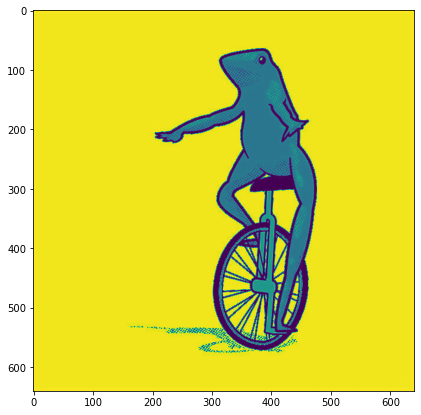

In [47]:
plt.figure(figsize=(7,7))
plt.imshow(frog_grey);

In [48]:
stub_image = np.zeros((4,4,1), dtype = np.uint8)

In [49]:
convolved_img_hori = oneDimConvolution(stub_image, conv_arr)

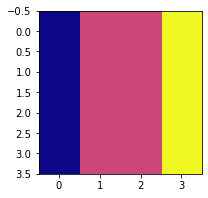

In [50]:
plt.figure(figsize=(3,3))
plt.imshow(convolved_img_hori.squeeze(-1), cmap = 'plasma');

In [51]:
convolved_frog_hori = oneDimConvolution(frog_grey, conv_arr)

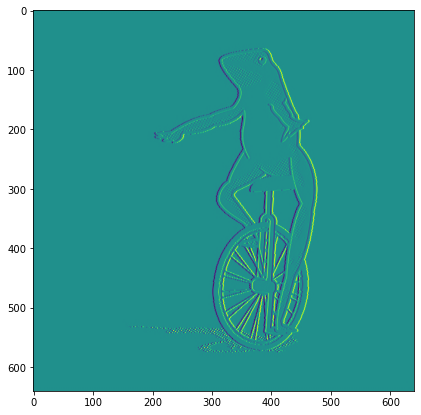

In [52]:
plt.figure(figsize=(7,7))
plt.imshow(convolved_frog_hori);

In [53]:
convolved_img_vert = oneDimConvolution(stub_image, conv_arr, False)

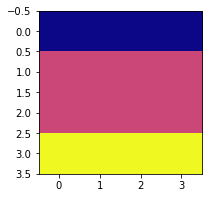

In [54]:
plt.figure(figsize=(3,3))
plt.imshow(convolved_img_vert.squeeze(-1), cmap = 'plasma');

In [55]:
convolved_frog_vert = oneDimConvolution(frog_grey, conv_arr, False)

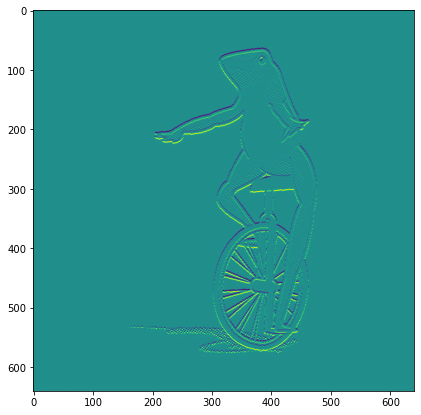

In [56]:
plt.figure(figsize=(7,7))
plt.imshow(convolved_frog_vert);

## Check when result is passed by refence

An input image with 8 bits is expected to receive a new 32 bit object when convolved once and the second time, the operation is expected to be done inplace.

In [57]:
conv_arr = derivative(3)

In [58]:
stub_image = np.zeros((4,4,1), dtype = np.uint8)

In [59]:
convolved_img_hori = oneDimConvolution(stub_image, conv_arr)

In [60]:
assert(np.linalg.norm(stub_image - stub_image) < 1e-7)

In [61]:
assert(np.linalg.norm(stub_image - convolved_img_hori) > 255)

In [62]:
conv_arr = gaussian(3)

In [63]:
convolved_img_vert = oneDimConvolution(convolved_img_hori, conv_arr, False)

In [64]:
assert(np.linalg.norm(convolved_img_vert - convolved_img_hori) < 1e-7)

##  Export

In [65]:
!python notebook2script.py Convolutions1D.ipynb

Converted Convolutions1D.ipynb to Export\nb_Convolutions1D.py
